In [1]:
# windows only hack for graphviz path 
import os
for path in os.environ['PATH'].split(os.pathsep):
    if path.endswith("Library\\bin"):
        os.environ['PATH']+=os.pathsep+os.path.join(path, 'graphviz')

In [2]:
# 設定環境變數來控制 keras, theano
os.environ['KERAS_BACKEND']="tensorflow"
#os.environ['THEANO_FLAGS']="floatX=float32, device=cuda"

In [3]:
import keras
from keras.models import Sequential
from PIL import Image
import numpy as np

Using TensorFlow backend.


In [4]:
import keras.backend as K
# 設定 channels_first 或 channels_last
K.set_image_data_format('channels_last')

In [5]:
base_model = keras.applications.vgg16.VGG16(weights='imagenet',  include_top=False, input_shape=(64,64,3))

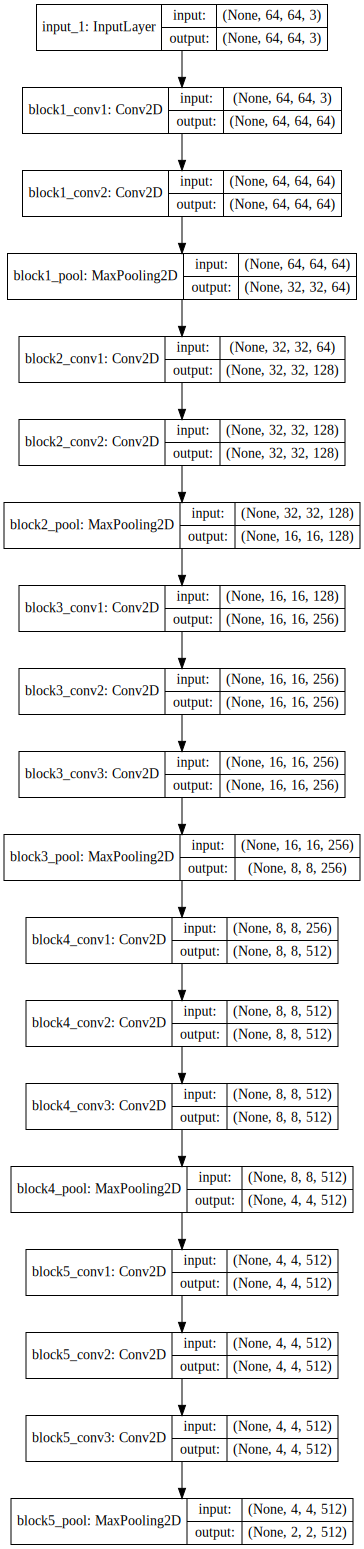

In [6]:
# 看 base_model
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
_ = base_model.get_layer("block5_conv3").output
_ = GlobalAveragePooling2D()(_)
_ = Dense(512, activation='relu')(_)
# 10 個輸出
predictions = Dense(10, activation='softmax')(_)
# 這是我們的 model
model = Model(inputs=base_model.input, outputs=predictions)

# 將原來的模型設定成不可訓練，只訓練上面的兩層 dense layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

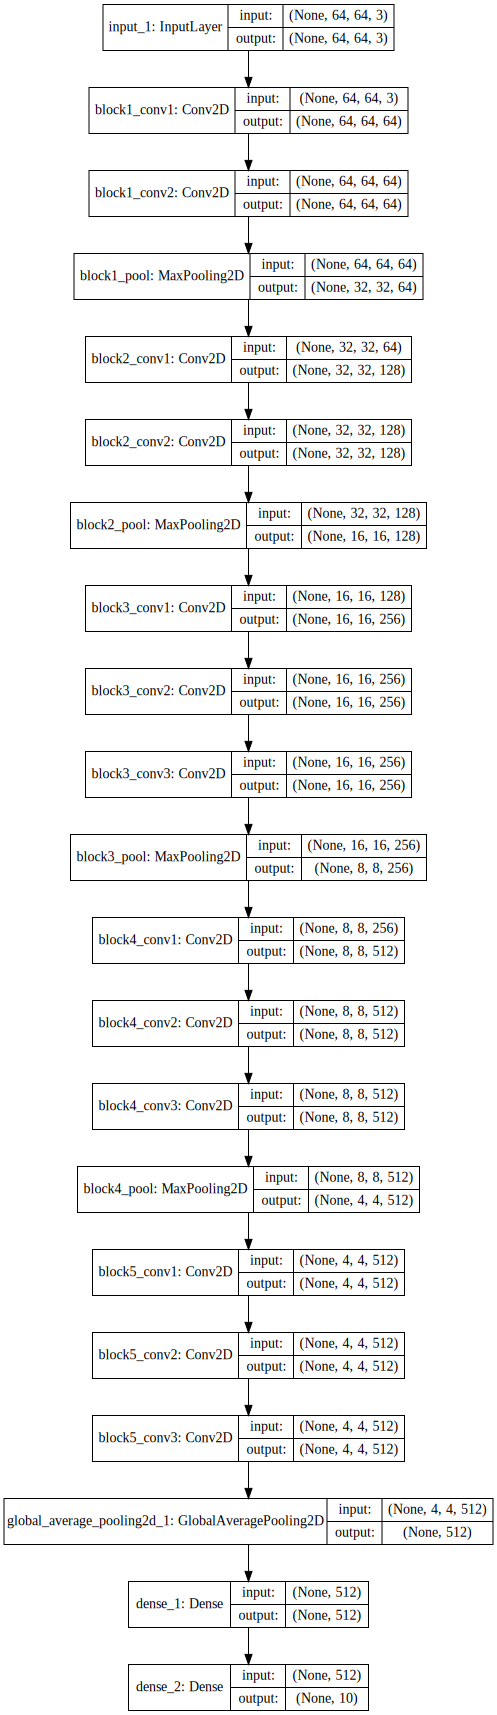

In [8]:
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
# 讀入之前的  mnist
import gzip
import pickle
with gzip.open("../Week02/mnist.pkl.gz", 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
train_X, train_y = train_set
test_X, test_y = test_set
validation_X, validation_y = validation_set

In [10]:
# 改變輸入圖形的大小並且處理
from keras.applications.vgg16 import preprocess_input

def resize_image(arr):
    img = Image.fromarray(arr.reshape(28,28))
    img = img.resize((64,64))
    img = img.convert("RGB")
    return np.array(img)
def preprocess_X(X):
    X = (X*255).clip(0,255).astype('uint8')
    X = X.reshape(-1, 28,28)
    X = np.float32([resize_image(X[i]) for i in range(X.shape[0])])
    return preprocess_input(X)

In [11]:
from PIL import Image
from IPython.display import display
def showX(X):
    int_X = (X*255).clip(0,255).astype('uint8')
    int_X_reshape = int_X.reshape(-1,28,28).swapaxes(0,1).reshape(28,-1)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])

In [12]:
import numpy as np
def generate(X, y):    
    while 1:
        idx = np.random.choice(X.shape[0], size=32, replace=False)    
        _X = preprocess_X(X[idx])
        Y = np.eye(10)[y[idx]]        
        yield (_X, Y)
v_data = (preprocess_X(validation_X[:200]), np.eye(10)[validation_y[:200]])
model.fit_generator(generate(train_X, train_y), steps_per_epoch=500, epochs=10, validation_data=v_data)

Epoch 1/10
500/500 [==============================] - 10s - loss: 0.4357 - acc: 0.8745 - val_loss: 0.1984 - val_acc: 0.9300
Epoch 2/10
500/500 [==============================] - 10s - loss: 0.2351 - acc: 0.9276 - val_loss: 0.1555 - val_acc: 0.9400
Epoch 3/10
500/500 [==============================] - 10s - loss: 0.1844 - acc: 0.9439 - val_loss: 0.1363 - val_acc: 0.9550
Epoch 4/10
500/500 [==============================] - 10s - loss: 0.1483 - acc: 0.9533 - val_loss: 0.1369 - val_acc: 0.9600
Epoch 5/10
500/500 [==============================] - 9s - loss: 0.1505 - acc: 0.9527 - val_loss: 0.1630 - val_acc: 0.9600
Epoch 6/10
500/500 [==============================] - 9s - loss: 0.1445 - acc: 0.9557 - val_loss: 0.1581 - val_acc: 0.9550
Epoch 7/10
500/500 [==============================] - 10s - loss: 0.1194 - acc: 0.9628 - val_loss: 0.1647 - val_acc: 0.9650
Epoch 8/10
500/500 [==============================] - 10s - loss: 0.1212 - acc: 0.9611 - val_loss: 0.1418 - val_acc: 0.9650
Epoch 9/10

In [13]:
# 實際
predictions = (model.predict(preprocess_X(test_X))).argmax(axis=1)

In [14]:
(predictions == test_y).mean()

0.94710000000000005

In [15]:
print(predictions[:30])
showX(test_X[:30])

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 8 4 9 6 6 5 4 0 7 4 0 1]


### 往前微調幾層

In [16]:
for n in ["block5_conv1", "block5_conv2", "block5_conv3"]:
    model.get_layer(n).trainable = True
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

In [17]:
model.fit_generator(generate(train_X, train_y), steps_per_epoch=500, epochs=10, validation_data=v_data)

Epoch 1/10
500/500 [==============================] - 15s - loss: 0.1725 - acc: 0.9572 - val_loss: 0.0419 - val_acc: 0.9850
Epoch 2/10
500/500 [==============================] - 15s - loss: 0.0709 - acc: 0.9798 - val_loss: 0.0694 - val_acc: 0.9750
Epoch 3/10
500/500 [==============================] - 15s - loss: 0.0612 - acc: 0.9823 - val_loss: 0.0668 - val_acc: 0.9900
Epoch 4/10
500/500 [==============================] - 15s - loss: 0.0487 - acc: 0.9856 - val_loss: 0.0703 - val_acc: 0.9850
Epoch 5/10
500/500 [==============================] - 15s - loss: 0.0396 - acc: 0.9885 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 6/10
500/500 [==============================] - 15s - loss: 0.0368 - acc: 0.9892 - val_loss: 0.0246 - val_acc: 0.9900
Epoch 7/10
500/500 [==============================] - 15s - loss: 0.0367 - acc: 0.9898 - val_loss: 0.0272 - val_acc: 0.9900
Epoch 8/10
500/500 [==============================] - 15s - loss: 0.0344 - acc: 0.9902 - val_loss: 0.0412 - val_acc: 0.9850
Epoch 9/

In [18]:
predictions = (model.predict(preprocess_X(test_X))).argmax(axis=1)
(predictions == test_y).mean()

0.98770000000000002